In [1]:
%pip install --upgrade -q aiobotocore

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
boto3 1.35.0 requires botocore<1.36.0,>=1.35.0, but you have botocore 1.34.131 which is incompatible.
langchain-aws 0.1.6 requires boto3<1.35.0,>=1.34.51, but you have boto3 1.35.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [12]:
import boto3
import sagemaker
import time

sess = sagemaker.Session()
write_bucket = "sagemaker-studio-lome-ai-model"  # Your bucket name
write_prefix = "depth-anything-demo"

region = sess.boto_region_name
s3_client = boto3.client("s3", region_name=region)
sm_client = boto3.client("sagemaker", region_name=region)
sm_runtime_client = boto3.client("sagemaker-runtime")

sagemaker_role = sagemaker.get_execution_role()

# S3 location of your model
model_uri = f"s3://{write_bucket}/model.tar.gz"

# S3 path where data captured at endpoint will be stored
data_capture_uri = f"s3://{write_bucket}/{write_prefix}/data-capture"

In [14]:
# Retrieve a suitable PyTorch image (adjust version as needed)
from sagemaker import image_uris
training_image = image_uris.retrieve(framework="pytorch", region=region, version="2.3", image_scope="inference", instance_type='ml.t3.medium')

# Specify a unique model name
model_name = "depth-anything-serverless"
primary_container = {
    "Image": training_image,
    "ModelDataUrl": model_uri
}

model_matches = sm_client.list_models(NameContains=model_name)["Models"]
if not model_matches:
    model = sm_client.create_model(
        ModelName=model_name,
        PrimaryContainer=primary_container,
        ExecutionRoleArn=sagemaker_role
    )
else:
    print(f"Model with name {model_name} already exists! Change model name to create new")

Model with name depth-anything-serverless already exists! Change model name to create new


In [35]:
# Endpoint Config name
endpoint_config_name = f"{model_name}-config"

# Serverless config parameters
serverless_config = {
    "MemorySizeInMB": 3072,  # Choose from 1024, 2048, 3072, 4096, 5120, or 6144
    "MaxConcurrency": 10  # Maximum number of concurrent invocations, up to 200
}

endpoint_config_matches = sm_client.list_endpoint_configs(NameContains=endpoint_config_name)["EndpointConfigs"]
if not endpoint_config_matches:
    endpoint_config_response = sm_client.create_endpoint_config(
        EndpointConfigName=endpoint_config_name,
        ProductionVariants=[{
            "VariantName": "AllTraffic",
            "ModelName": model_name,
            "ServerlessConfig": serverless_config
        }]
    )
else:
    print(f"Endpoint config with name {endpoint_config_name} already exists! Change endpoint config name to create new")

In [36]:
endpoint_name = f"{model_name}-endpoint"

endpoint_matches = sm_client.list_endpoints(NameContains=endpoint_name)["Endpoints"]
if not endpoint_matches:
    endpoint_response = sm_client.create_endpoint(
        EndpointName=endpoint_name,
        EndpointConfigName=endpoint_config_name
    )
else:
    print(f"Endpoint with name {endpoint_name} already exists! Change endpoint name to create new")

resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
status = resp["EndpointStatus"]
while status == "Creating":
    print(f"Endpoint Status: {status}...")
    time.sleep(60)
    resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
    status = resp["EndpointStatus"]
print(f"Endpoint Status: {status}")

Endpoint Status: Creating...
Endpoint Status: Creating...
Endpoint Status: Creating...
Endpoint Status: InService


Result size: 1233837
First 100 bytes of result: b'['
Depth map shape before reshaping: (250, 250)


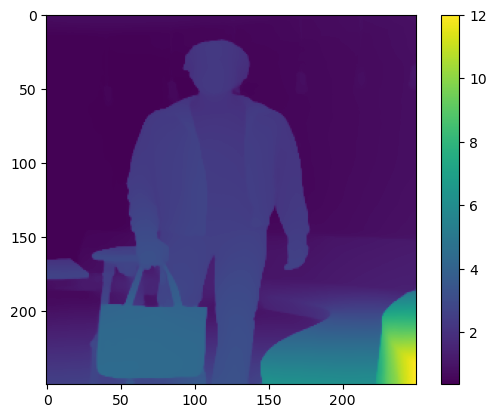

In [66]:
import torch
from PIL import Image
import io
import numpy as np
import matplotlib.pyplot as plt
import json

# Load and preprocess your image
image_path = "image.png"  # Replace with actual path
i = 250  #It can only do squares
with Image.open(image_path) as img:
    # Resize the image to a smaller size, e.g., 224x224
    img = img.resize((i, i))
    
    # Convert to RGB if it's not already
    img = img.convert('RGB')
    
    # Save as PNG in memory (matching your expected binary stream input)
    buffer = io.BytesIO()
    img.save(buffer, format="PNG")
    image_data = buffer.getvalue()

# Invoke the endpoint
response = sm_runtime_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="application/octet-stream",  # Set the content type to application/octet-stream
    Body=image_data
)

# Process the response (adjust based on your model's output format)
result = response["Body"].read()

# Decode the JSON-encoded string
decoded_result = json.loads(result)

# Print the length of the result and a small sample to understand its structure
print(f"Result size: {len(result)}")
print(f"First 100 bytes of result: {result[:1]}")

# Assuming your output is a flat array of floats, try reshaping accordingly
try:
    depth_map = np.array(decoded_result, dtype=np.float32)
    print(f"Depth map shape before reshaping: {depth_map.shape}")
    depth_map = depth_map.reshape((i, i))  # Adjust shape as needed
    plt.imshow(depth_map, cmap='viridis')
    plt.colorbar()
    plt.show()
except ValueError as e:
    print(f"Error reshaping the buffer: {e}")